## **Capstone Project - Car Detection**

#### Importing libraries

In [4]:
import pandas as pd
import numpy as np
from math import sqrt
import os
import h5py

import pickle
import logging
import random

from zipfile import ZipFile
import cv2
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

logging.getLogger().setLevel(logging.CRITICAL)

# from sklearn.preprocessing import Normalizer, LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, f1_score, make_scorer
# from sklearn.svm import SVC


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, Reshape, UpSampling2D, Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, Dropout, ZeroPadding2D ,BatchNormalization
from tensorflow.keras.models import Model, Sequential

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

from tensorflow.keras.optimizers import Adam, SGD
# # from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# import cvlib as cv
# from PIL import Image




### <font color='blue'>**1. Import the dataset**</font>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
file = os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')  #change dir

In [7]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Capstone


####Import data in dataframes

In [ ]:
#Different car labels
car_names = pd.read_csv( 'Car names and make.csv', header=None, names = ['CarLabel'] )

#Train data
train_data = pd.read_csv( 'Annotations/Train Annotations.csv', skiprows=1, names = ['ImageName', 'X1', 'Y1', 'X2' , 'Y2', 'Class'] )

#Test data
test_data = pd.read_csv( 'Annotations/Test Annotation.csv' , skiprows=1, names = ['ImageName', 'X1', 'Y1', 'X2' , 'Y2', 'Class'])

#Display few sample records
print (car_names.head() )
print ( )
print (train_data.head() )
print ( )
print (test_data.head() )

                     CarLabel
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

   ImageName   X1   Y1    X2    Y2  Class
0  00001.jpg   39  116   569   375     14
1  00002.jpg   36  116   868   587      3
2  00003.jpg   85  109   601   381     91
3  00004.jpg  621  393  1484  1096    134
4  00005.jpg   14   36   133    99    106

   ImageName   X1   Y1   X2   Y2  Class
0  00001.jpg   30   52  246  147    181
1  00002.jpg  100   19  576  203    103
2  00003.jpg   51  105  968  659    145
3  00004.jpg   67   84  581  407    187
4  00005.jpg  140  151  593  339    185


<b> Find class name with '/' 

In [ ]:
for i in range(len(car_names)) :
  if '/' in car_names.loc[i,"CarLabel"]:
    print(car_names.loc[i,"CarLabel"])
    print(i)

Ram C/V Cargo Van Minivan 2012
173


Thus, there is only 1 class with '/' in it's name. 

In [ ]:
#Replace '/' with '-' in the name
car_names.loc[173,'CarLabel'] = 'Ram C-V Cargo Van Minivan 2012'

Also, check and manually rename the folder. As checked, folder already has '-' in the name

### <font color='blue'>**2. Map training images to its classes and annotations.**</font>

In [ ]:
car_names['Class'] = car_names.index + 1
car_train_df = pd.merge(train_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_train_df.head() 

,ImageName,X1,Y1,X2,Y2,Class,CarLabel
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


### <font color='blue'>**3. Map Test images to its classes and annotations.**</font>

In [ ]:
car_test_df = pd.merge(test_data, car_names, how = 'left', left_on='Class', right_on='Class' )
car_test_df.head() 

,ImageName,X1,Y1,X2,Y2,Class,CarLabel
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012


### <font color='blue'>**4. Display images with bounding box.**</font>

In [ ]:
IMAGE_SIZE = 224
IMAGE_HEIGHT = IMAGE_SIZE
IMAGE_WIDTH = IMAGE_SIZE

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

Generating bounding boxes images for Eg Train Data


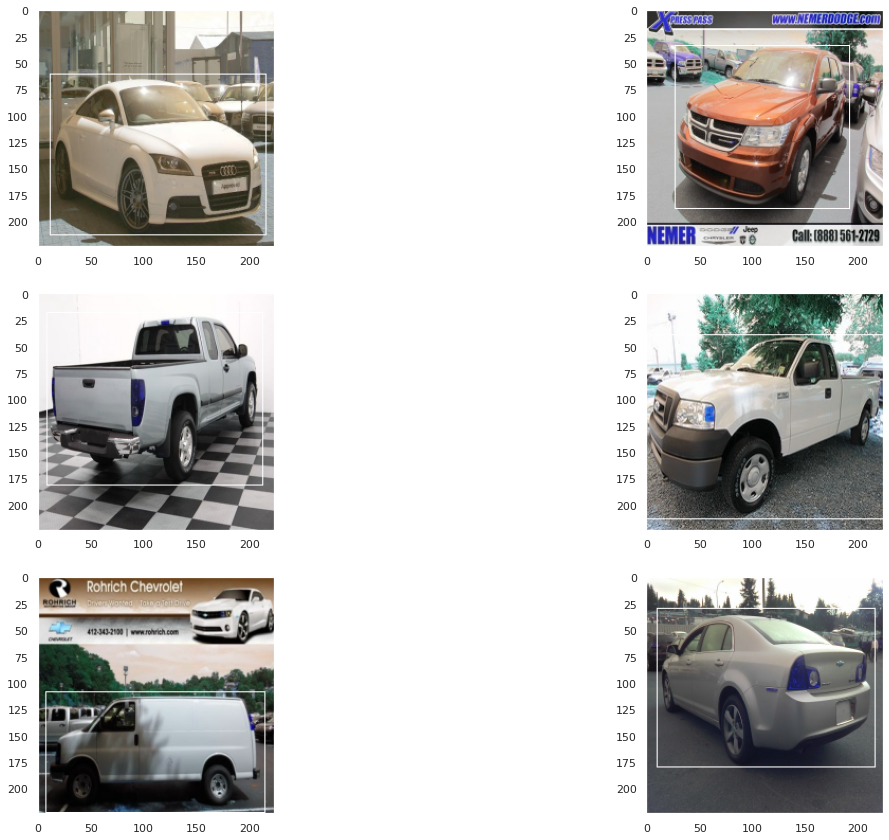

In [ ]:
print ( 'Generating bounding boxes images for Eg Train Data')

i = 1
plt.figure(figsize=(20,20))
for no in [0 , 6, 67, 89 , 99, 340 ]:
    eg_car  = car_train_df.iloc[ no ]
    
    path = 'Car Images/Train Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
    img = cv2.imread( path )
    img_shape = img.shape
    img = cv2.resize(img, dsize = (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    

    x1 = int(eg_car['X1']   * IMAGE_SIZE  / img_shape[1] -3 )           # Normalize bounding box by image size 
    y1 = int(eg_car['Y1']   * IMAGE_SIZE / img_shape[0] - 3 )        # Normalize bounding box by image size
    x2 = int(eg_car['X2']   * IMAGE_SIZE / img_shape[1] + 3)           # Normalize bounding box by image size
    y2 = int(eg_car['Y2']   * IMAGE_SIZE / img_shape[0] + 3 )          # Normalize bounding box by image size

    
    cv2.rectangle(img, (x1, y1), (x2, y2), (255,255,255) )

    i +=1
    plt.subplot(4,2,i+1)    
    plt.grid(False)
    plt.imshow(img);


### <font color='blue'>**5. Save training images with bounding box.**</font>





<b> While trying to read few images using cv2, I was getting return type as None. After troubleshooting, I found that this is due to folder name of images. Some of folder names have a '/' in it. Therefore, we will need to remove it. We have done it as part of pre-processing step.

In [ ]:
import os
file = os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')  #change dir

<b> We will extract bounding boxes and then save those as image

In [ ]:
for i in range(len(car_train_df)):
  eg_car  = car_train_df.iloc[i]
  source_path = 'Car Images/Train Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
  dest_path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )

  image = cv2.imread(source_path)
  if image is None:
    print(source_path)

  x1 = int(eg_car['X1'])          
  y1 = int(eg_car['Y1'])        
  x2 = int(eg_car['X2'])      
  y2 = int(eg_car['Y2'])    

  im2 = image[y1:y2,x1:x2]

  destdirname = 'Car Images/Train Images Annoted/{0}'.format( eg_car['CarLabel'])
  destfilename= eg_car['ImageName']

  if not os.path.exists(destdirname):
    os.mkdir(destdirname)

  cv2.imwrite(os.path.join(destdirname, destfilename), im2)


### Display few cropped training images

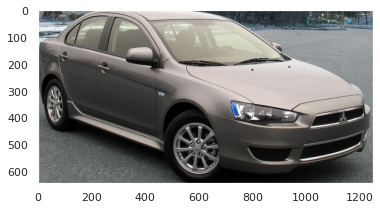

In [ ]:
eg_car  = car_train_df.iloc[8]
path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

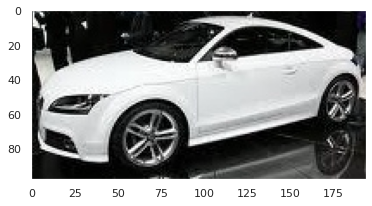

In [ ]:
eg_car  = car_train_df.iloc[16]
path = 'Car Images/Train Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

### <font color='blue'>**6. Save test images with bounding box.**</font>

<b> We will extract bounding boxes and then save those as image

In [ ]:
for i in range(len(car_test_df)):
  eg_car  = car_test_df.iloc[i]
  source_path = 'Car Images/Test Images/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
  dest_path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )

  image = cv2.imread(source_path)
  if image is None:
    print(source_path)

  x1 = int(eg_car['X1'])          
  y1 = int(eg_car['Y1'])        
  x2 = int(eg_car['X2'])      
  y2 = int(eg_car['Y2'])    

  im2 = image[y1:y2,x1:x2]

  destdirname = 'Car Images/Test Images Annoted/{0}'.format( eg_car['CarLabel'])
  destfilename= eg_car['ImageName']

  if not os.path.exists(destdirname):
    os.mkdir(destdirname)

  cv2.imwrite(os.path.join(destdirname, destfilename), im2)

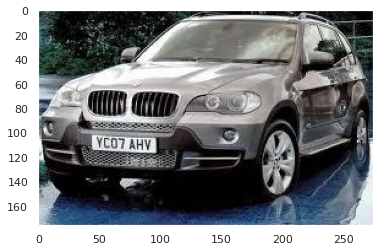

In [ ]:
eg_car  = car_test_df.iloc[8]
path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

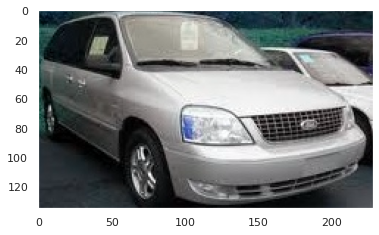

In [ ]:
eg_car  = car_test_df.iloc[11]
path = 'Car Images/Test Images Annoted/{0}/{1}'.format( eg_car['CarLabel'], eg_car['ImageName'] )
img = cv2.imread( path )
plt.grid(False)
plt.imshow(img)

In [8]:
###Loading the data to train & test using Image Data Generator  
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create data generator for training data with data augmentation and normalizing all
# values by 255

train_path = 'Car Images/Train Images Annoted'

test_path = 'Car Images/Test Images Annoted'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

generator = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,validation_split=0.3)


test_datagen = ImageDataGenerator(rescale = 1./255)

# Setting training data generator's source directory
# Setting the target size to resize all the images 

training_set = generator.flow_from_directory(train_path,
                                                 target_size = IMG_SIZE ,
                                                 batch_size = BATCH_SIZE,class_mode = 'categorical',
                                                subset='training')

# Setting testing data generator's source directory - validation data

test_set = generator.flow_from_directory(test_path,
                                            target_size = IMG_SIZE ,
                                                 batch_size = BATCH_SIZE,class_mode = 'categorical',
                                           subset='validation')



Found 5796 images belonging to 196 classes.
Found 2317 images belonging to 196 classes.


In [9]:
### Checking if both test and train class names are matching

labels = (training_set.class_indices)

print(labels.items())

print()

labels_test = (test_set.class_indices)

print(labels_test.items())


print()

is_true= np.array_equal(np.unique(labels),np.unique(labels_test))


print("Is test & training class names matching :",is_true)




dict_items([('AM General Hummer SUV 2000', 0), ('Acura Integra Type R 2001', 1), ('Acura RL Sedan 2012', 2), ('Acura TL Sedan 2012', 3), ('Acura TL Type-S 2008', 4), ('Acura TSX Sedan 2012', 5), ('Acura ZDX Hatchback 2012', 6), ('Aston Martin V8 Vantage Convertible 2012', 7), ('Aston Martin V8 Vantage Coupe 2012', 8), ('Aston Martin Virage Convertible 2012', 9), ('Aston Martin Virage Coupe 2012', 10), ('Audi 100 Sedan 1994', 11), ('Audi 100 Wagon 1994', 12), ('Audi A5 Coupe 2012', 13), ('Audi R8 Coupe 2012', 14), ('Audi RS 4 Convertible 2008', 15), ('Audi S4 Sedan 2007', 16), ('Audi S4 Sedan 2012', 17), ('Audi S5 Convertible 2012', 18), ('Audi S5 Coupe 2012', 19), ('Audi S6 Sedan 2011', 20), ('Audi TT Hatchback 2011', 21), ('Audi TT RS Coupe 2012', 22), ('Audi TTS Coupe 2012', 23), ('Audi V8 Sedan 1994', 24), ('BMW 1 Series Convertible 2012', 25), ('BMW 1 Series Coupe 2012', 26), ('BMW 3 Series Sedan 2012', 27), ('BMW 3 Series Wagon 2012', 28), ('BMW 6 Series Convertible 2007', 29), ('


### <font color='blue'> 7.  Building CNN classifier</font>

In [10]:
# Initialising the CNN classifier
classifier = Sequential()

INPUT_SIZE = (224, 224, 3)


# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = INPUT_SIZE, activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))


# The final output layer with output size 196 classes for  the categorical classifcation
classifier.add(Dense(units = 196, activation = 'softmax'))

In [11]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:

early = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=40,verbose=1,mode='auto')

# There are 3823 training images and 500 test images in total
hist_CNNClassifier = classifier.fit(training_set,
                         steps_per_epoch = int(training_set.samples/BATCH_SIZE),
                         epochs = 20,
                         validation_data = test_set,
                         validation_steps = int(test_set.samples/BATCH_SIZE),
                         callbacks = [early])

Epoch 1/20
181/181 [==============================] - 2204s 12s/step - loss: 5.2822 - accuracy: 0.0047 - val_loss: 5.2769 - val_accuracy: 0.0074
Epoch 2/20
181/181 [==============================] - 452s 2s/step - loss: 5.2786 - accuracy: 0.0073 - val_loss: 5.2759 - val_accuracy: 0.0087
Epoch 3/20
181/181 [==============================] - 452s 2s/step - loss: 5.2721 - accuracy: 0.0083 - val_loss: 5.2569 - val_accuracy: 0.0091
Epoch 4/20
181/181 [==============================] - 451s 2s/step - loss: 5.2053 - accuracy: 0.0101 - val_loss: 5.1442 - val_accuracy: 0.0091
Epoch 5/20
181/181 [==============================] - 451s 2s/step - loss: 5.0732 - accuracy: 0.0186 - val_loss: 5.0251 - val_accuracy: 0.0174
Epoch 6/20
181/181 [==============================] - 451s 2s/step - loss: 4.9173 - accuracy: 0.0311 - val_loss: 4.8992 - val_accuracy: 0.0312
Epoch 7/20
181/181 [==============================] - 451s 2s/step - loss: 4.7218 - accuracy: 0.0461 - val_loss: 4.7973 - val_accuracy: 0.04

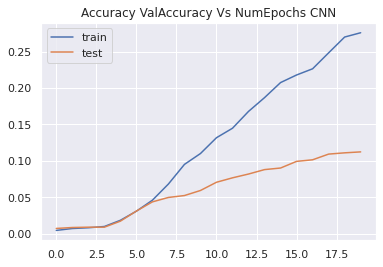

<function matplotlib.pyplot.show>

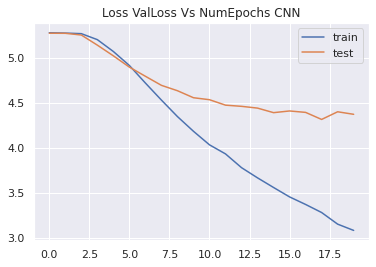

In [13]:
train_loss = hist_CNNClassifier.history['loss']
val_loss   = hist_CNNClassifier.history['val_loss']

xc = hist_CNNClassifier.epoch
plt.title("Accuracy ValAccuracy Vs NumEpochs CNN")
plt.plot(xc,hist_CNNClassifier.history['accuracy'], label='train')
plt.plot(xc,hist_CNNClassifier.history['val_accuracy'], label='test')
plt.legend()
plt.show()

plt.figure()
plt.title("Loss ValLoss Vs NumEpochs CNN")
plt.plot(xc, train_loss,label='train')
plt.plot(xc, val_loss,label='test')
plt.legend()
plt.show

<font color='blue'>** pickle CNN classifier model and weights **</font>

In [15]:
classifier.save('./classifier.h5')

classifier.save_weights('./classifier_weights.h5')

<font color='blue'>**8. Building Resnet50 model.**</font>



In [ ]:
from  tensorflow.keras.applications import resnet50
resnet50 = resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#for layer in conv_model.layers: 
 #   layer.trainable = False

x = Flatten()(conv_model.layers[-1].output)

#x = Flatten()(conv_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(224, activation='relu')(x)
x = Dense(224, activation='relu')(x)

predictions = Dense(196, activation='softmax')(x)

full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
## compiling resnet50 model 
opt= Adam(learning_rate=0.01)
full_model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
early = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=40,verbose=1,mode='auto')
   

In [ ]:
full_model.fit(training_set,steps_per_epoch = 2, epochs =30, validation_data = test_set,
		        validation_steps = 1,callbacks = [early])

Epoch 1/30
2/2 [==============================] - 67s 33s/step - loss: 169.4210 - accuracy: 0.0000e+00 - val_loss: 1736714183770112.0000 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 58s 31s/step - loss: 125.3960 - accuracy: 0.0000e+00 - val_loss: 30414204663400235008.0000 - val_accuracy: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 56s 30s/step - loss: 6.5134 - accuracy: 0.0156 - val_loss: 16305093299710531207168.0000 - val_accuracy: 0.0000e+00
Epoch 4/30
2/2 [==============================] - 57s 31s/step - loss: 5.4050 - accuracy: 0.0000e+00 - val_loss: 56311528056363277090816.0000 - val_accuracy: 0.0000e+00
Epoch 5/30
2/2 [==============================] - 56s 31s/step - loss: 5.2940 - accuracy: 0.0000e+00 - val_loss: 24887598605990858063872.0000 - val_accuracy: 0.0312
Epoch 6/30
2/2 [==============================] - 57s 31s/step - loss: 5.6139 - accuracy: 0.0156 - val_loss: 5628538015692676399104.0000 - val_accuracy: 0.0000e+00
Epoch